# Imports

In [1]:
import os
import sys
import glob
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import torchvision.transforms as transforms
from collections import defaultdict
import pickle
from datetime import datetime
import pandas as pd
!rm -rf semantic-correspondence

!git clone https://github.com/MarcotteS/semantic-correspondence.git
import sys
sys.path.append('/content/semantic-correspondence/src')

import fine_tunning.test as ft
import importlib
importlib.reload(ft)


Cloning into 'semantic-correspondence'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 223 (delta 2), reused 5 (delta 2), pack-reused 215 (from 1)
Receiving objects: 100% (223/223), 2.42 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (125/125), done.


<module 'fine_tunning.test' from '/content/semantic-correspondence/src/fine_tunning/test.py'>

# Download and unzip dataset

In [2]:
!wget https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

--2026-01-21 16:42:48--  https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
Resolving cvlab.postech.ac.kr (cvlab.postech.ac.kr)... 141.223.85.126
Connecting to cvlab.postech.ac.kr (cvlab.postech.ac.kr)|141.223.85.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226961117 (216M) [application/x-gzip]
Saving to: ‘SPair-71k.tar.gz’

SPair-71k.tar.gz    100%[===================>] 216.45M  15.8MB/s    in 14s     

2026-01-21 16:43:03 (15.3 MB/s) - ‘SPair-71k.tar.gz’ saved [226961117/226961117]



In [3]:
!tar -xf SPair-71k.tar.gz

# Dataset

In [4]:
from dataset import SPairDataset,denorm,draw_image_with_keypoints,visualize_sample,collate_fn_correspondence

# Models

In [5]:
from models import DINOv2Extractor,DINOv3Extractor,SAMExtractor

# Correspondence Matcher

In [6]:
from correspondence import CorrespondenceMatcher

# Evaluator

In [7]:
from evaluation import CorrespondenceEvaluator,evaluate_model

In [8]:
from analyzer import ResultsAnalyzer

# DINOv2

In [9]:
image_size = 518 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:02<00:00, 6013.05it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
# Initialize model (DINOv2)
extractor = DINOv2Extractor(model_name="dinov2_vitb14")
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 237MB/s]
Evaluating: 100%|██████████| 765/765 [37:59<00:00,  2.98s/it]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 36.93%
  PCK@0.10: 53.93%
  PCK@0.15: 63.38%
  PCK@0.20: 69.93%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 54.74% | 0.10: 69.65% | 0.15: 76.86% | 0.20: 82.21%
  bicycle         → 0.05: 40.95% | 0.10: 60.01% | 0.15: 68.24% | 0.20: 75.09%
  bird            → 0.05: 64.63% | 0.10: 84.22% | 0.15: 91.17% | 0.20: 94.80%
  boat            → 0.05: 19.43% | 0.10: 33.28% | 0.15: 44.83% | 0.20: 52.72%
  bottle          → 0.05: 24.15% | 0.10: 41.45% | 0.15: 52.01% | 0.20: 59.61%
  bus             → 0.05: 35.19% | 0.10: 50.09% | 0.15: 56.92% | 0.20: 61.63%
  car             → 0.05: 31.18% | 0.10: 47.19% | 0.15: 53.76% | 0.20: 58.94%
  cat             → 0.05: 57.92% | 0.10: 67.99% | 0.15: 75.28% | 0.20: 80.98%
  chair           → 0.05: 25.33% | 0.10: 36.06% | 0.15: 45.15% | 0.20: 52.25%
  cow             → 0.0

In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


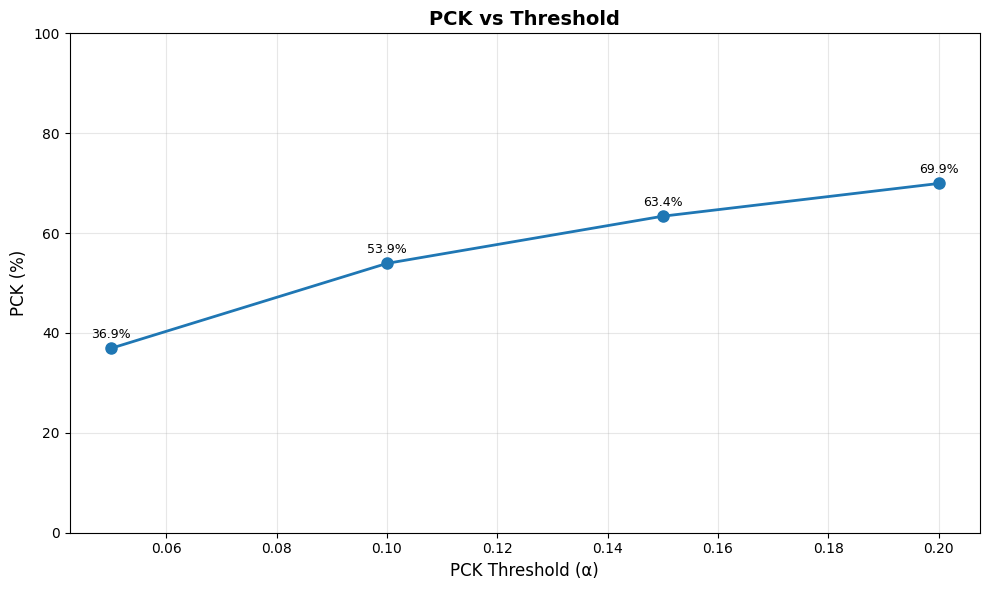

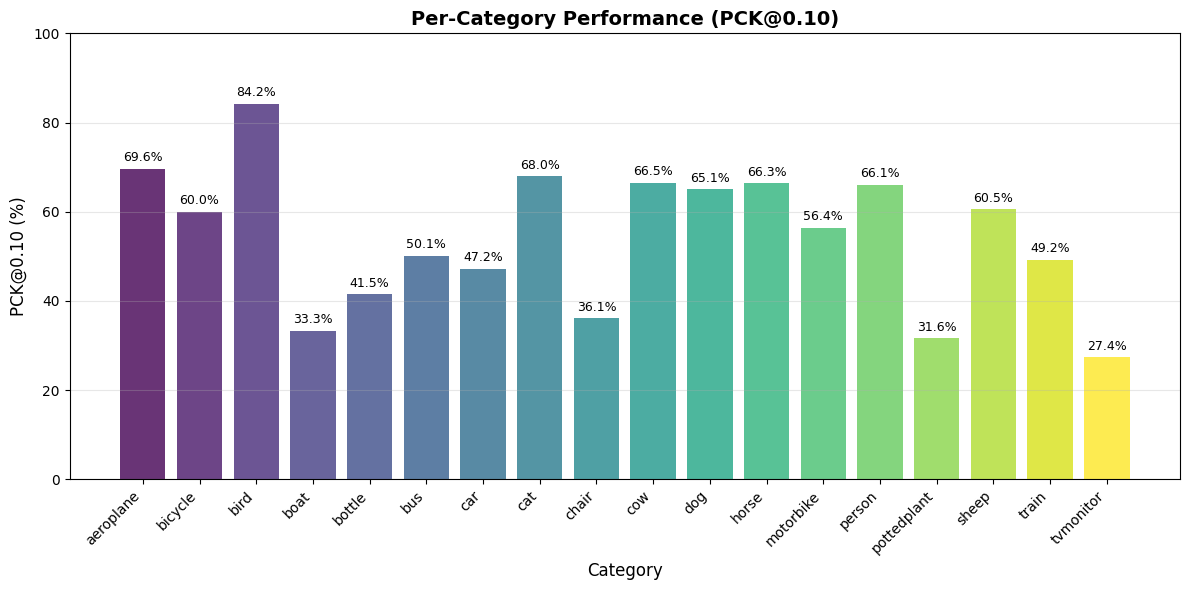

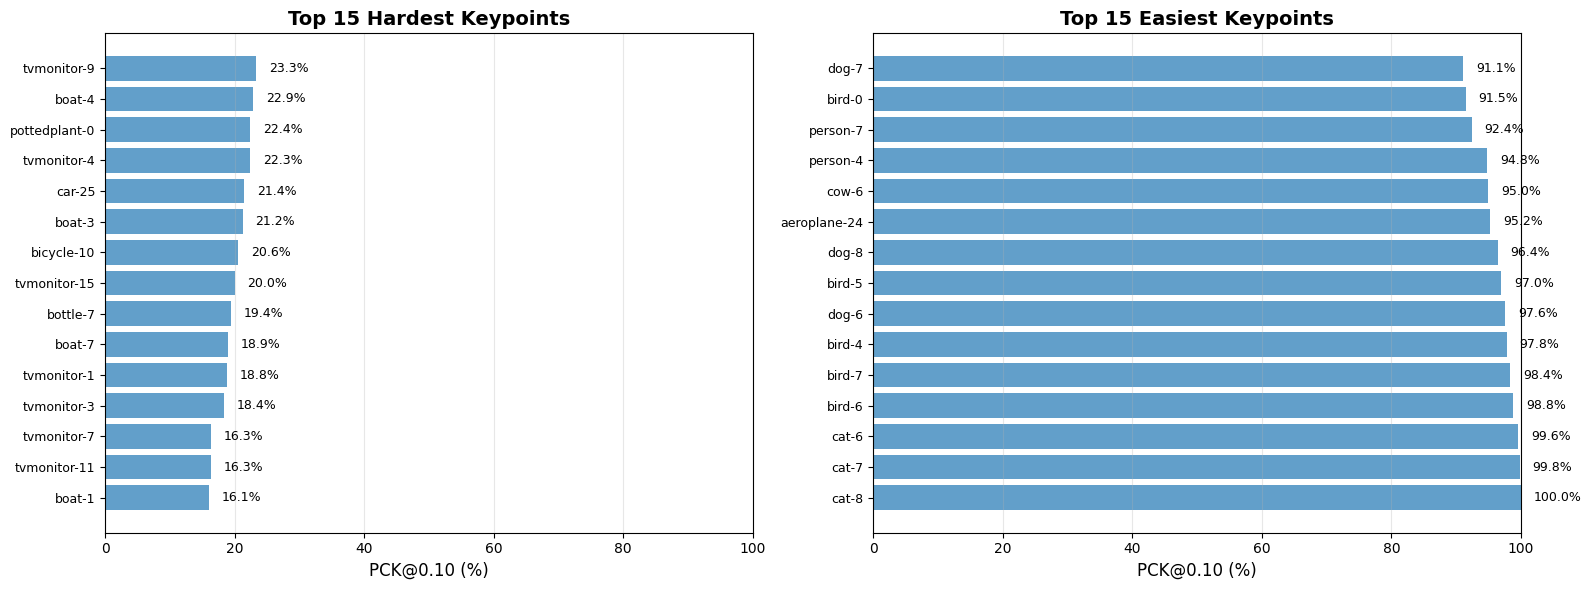

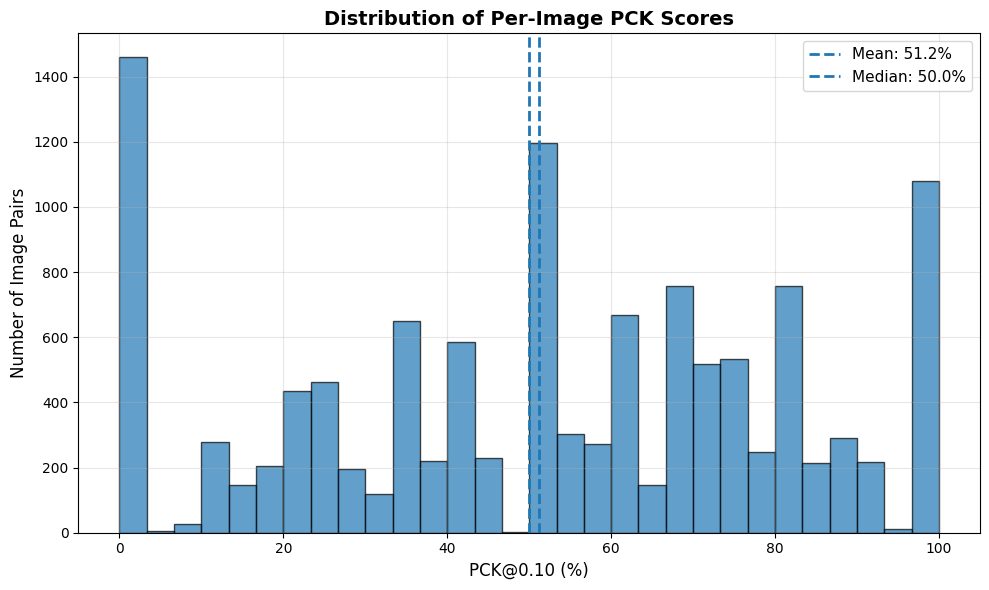

✅ Exported all metrics to ./results/dinov2_vitb14/
✅ Report generated in ./results/dinov2_vitb14/
   Overall PCK  aeroplane    bicycle       bird       boat     bottle  \
0    53.930803  69.647401  60.010347  84.222631  33.284111  41.451261   

         bus        car        cat      chair        cow        dog  \
0  50.089326  47.188196  67.989674  36.062432  66.517357  65.056227   

       horse  motorbike     person  pottedplant  sheep      train  tvmonitor  
0  66.347789  56.378601  66.061453    31.576616   60.5  49.226328  27.375442  


In [12]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov2_vitb14')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

# DINOv3

In [9]:
!git clone https://github.com/facebookresearch/dinov3.git

Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 538 (delta 201), reused 99 (delta 99), pack-reused 175 (from 1)
Receiving objects: 100% (538/538), 9.88 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [10]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.9 MB/s eta 0:00:00


In [11]:
# You need to go to DINOv3 repo and from download section request for access and put the URL here or just use my link
checkpoint_path = "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNmt0Y2lrdHZodmt4dG92dm41ajZrNmdsIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3Njc3NDM4ODZ9fX1dfQ__&Signature=Oo15SCsLwsN9zW-rhSAzIkZGaRPl3VBGnzOjgpGgs8zJC5RsjAPjaA2emXitvCNWCUDkBkxO-wrYyhLVjR5LB9euV7S4dPRunVY1W1tIqH7hbfgQJtNJis3hdz0SDJe4YRQc6BU3GEKxal5m7d69lIBcz3BPyTE9FWkgcbKgOLESrZuY32zmZFhQrpr7TaQQbUjBY9XWb2ais8B5FjgrcuEOj%7E5ECznFTRSsfc57Ai1WtVjt5UD-jSJPahxsPj2EMbe3TYAzkxzhXIjv7pT75QBcmgk2lNuXC3YsijBhNBn%7EAbaC3H5c9mDaE4xiGQ8II-OM-geu3QE2P1rLXLfvJQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1644049136628051"

In [12]:
image_size = 512 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 6507.26it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
# Initialize model (DINOv3)
extractor = DINOv3Extractor(repo_dir='dinov3', weights=checkpoint_path)
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Downloading: "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiYTd1MmRsZXh1dWZkbmxwdW85NXR4OGtxIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NjkxODEzNDR9fX1dfQ__&Signature=S9qHXQHbm-npSyVB1ajoLJh8LfriOyqBl2Cbwo85x4rdCnWpwiemXbhpApOpodvEyTzABKP6kXp6cZBv%7EIhciMMmIC1CbTuZCr5YgCzkQI8md3U6TIfSTc-dndKeBmdu8JKbNfjn6cIzoI16ufVp0gM-7HnKf3U4RBZTKjPHjg7C75b-HiruHNj3InG2IdEMKawl1wYOPMUzgjlMlYO4yhMsVG3LNfD9Bw9r78XitTCp8aM5TUsBRWm3Lkh%7EC51H1YatfFQHfL7pbJq8M-AjlgkOWj68wOjixlKk9T6vWGj2D7%7EhlaynAovwJpHf9D%7EZ0v8laNKRBiquODY2sdfRgg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1155630459759052" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


100%|██████████| 327M/327M [00:07<00:00, 47.6MB/s]
Evaluating:   0%|          | 0/765 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 765/765 [30:17<00:00,  2.38s/it]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 35.61%
  PCK@0.10: 53.01%
  PCK@0.15: 62.17%
  PCK@0.20: 68.04%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 39.37% | 0.10: 53.93% | 0.15: 62.07% | 0.20: 67.14%
  bicycle         → 0.05: 33.57% | 0.10: 49.46% | 0.15: 57.50% | 0.20: 64.25%
  bird            → 0.05: 53.36% | 0.10: 75.92% | 0.15: 83.81% | 0.20: 87.79%
  boat            → 0.05: 13.85% | 0.10: 25.46% | 0.15: 33.87% | 0.20: 40.55%
  bottle          → 0.05: 29.91% | 0.10: 45.24% | 0.15: 54.03% | 0.20: 59.90%
  bus             → 0.05: 33.16% | 0.10: 47.68% | 0.15: 54.42% | 0.20: 58.80%
  car             → 0.05: 31.68% | 0.10: 47.66% | 0.15: 53.98% | 0.20: 58.66%
  cat             → 0.05: 58.58% | 0.10: 69.14% | 0.15: 75.70% | 0.20: 80.28%
  chair           → 0.05: 24.95% | 0.10: 37.54% | 0.15: 44.88% | 0.20: 51.78%
  cow             → 0.0

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov3_vitb16"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


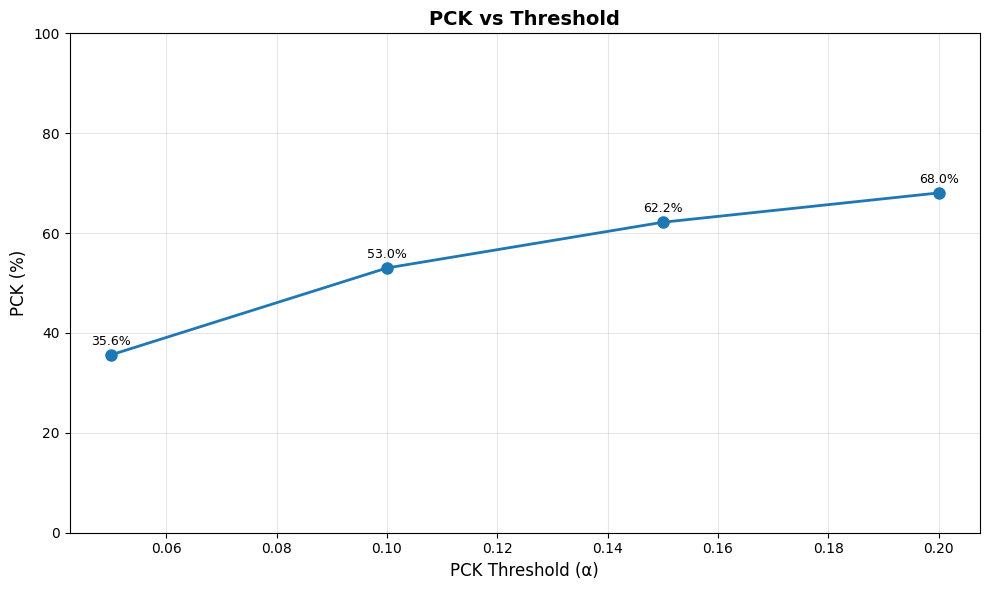

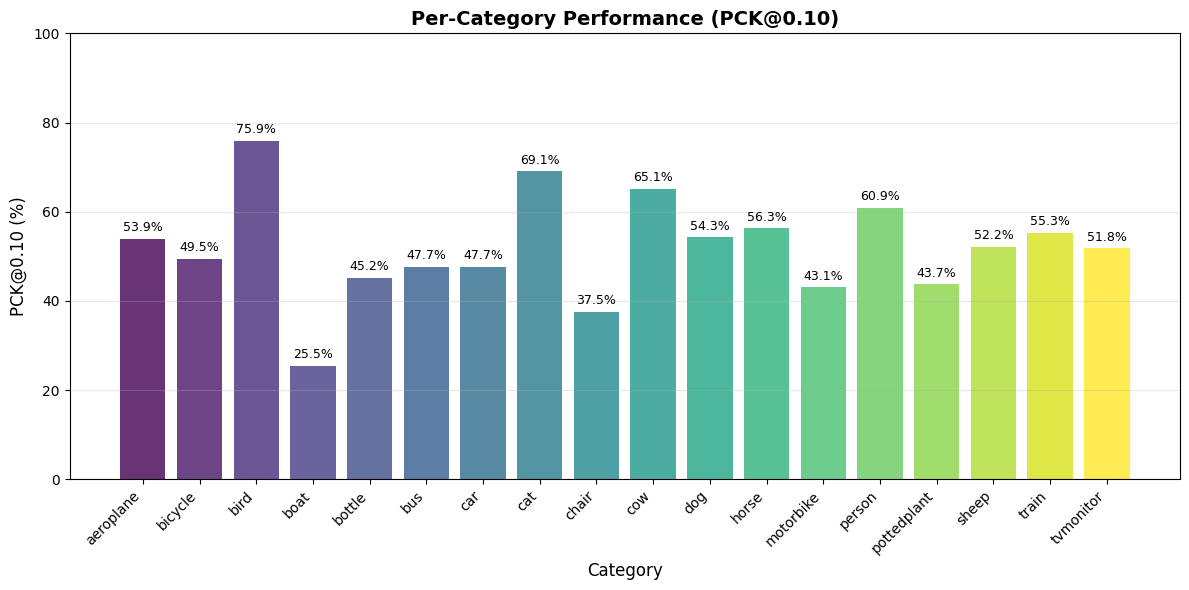

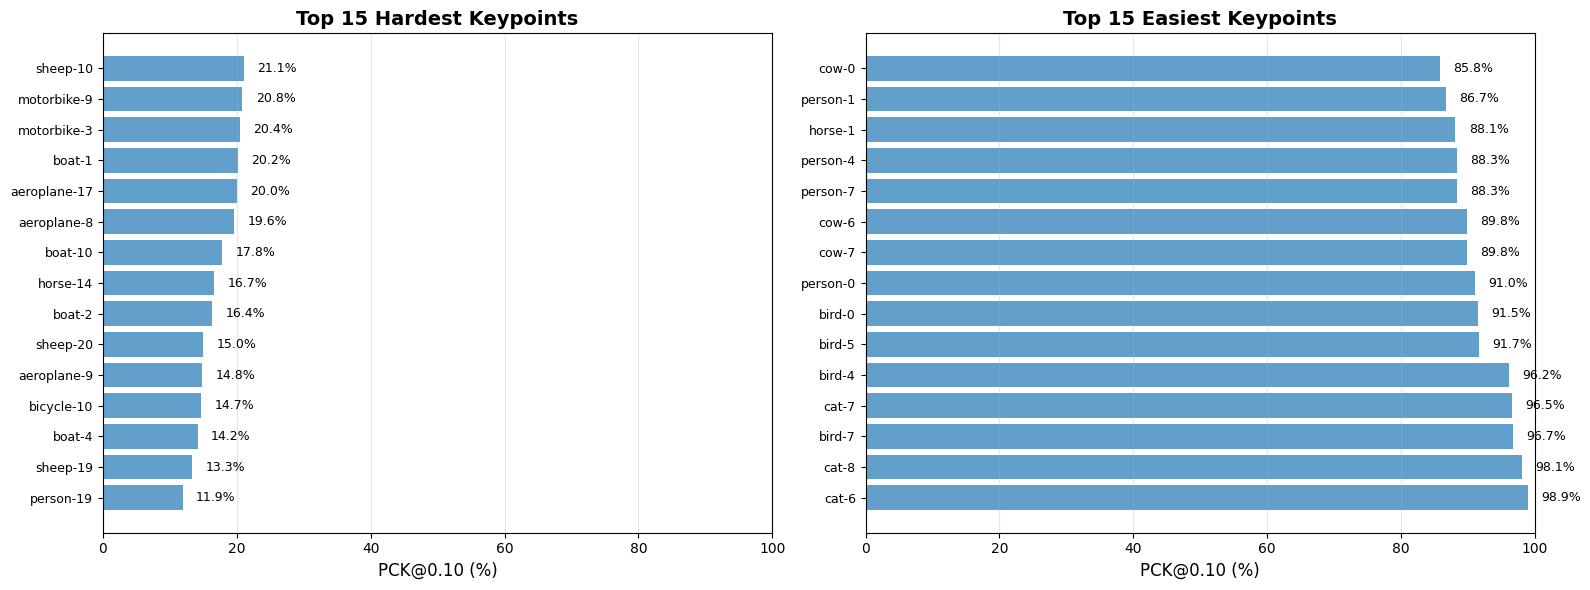

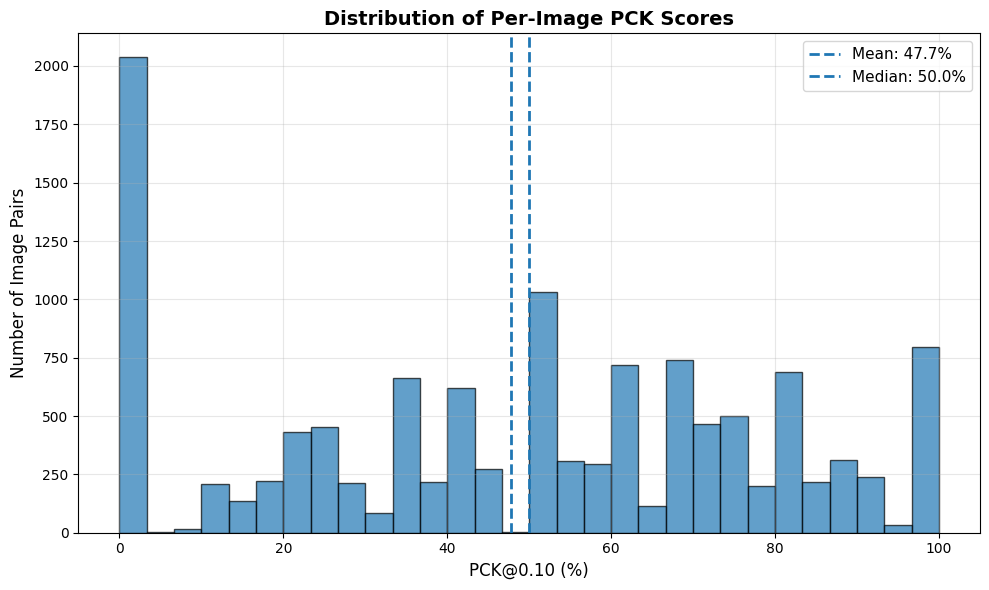

✅ Exported all metrics to ./results/dinov3_vitb16/
✅ Report generated in ./results/dinov3_vitb16/
   Overall PCK  aeroplane    bicycle       bird       boat     bottle  \
0    53.011503  53.925845  49.456803  75.919963  25.457767  45.235129   

         bus       car        cat      chair        cow        dog      horse  \
0  47.677535  47.66147  69.135205  37.541073  65.136245  54.289879  56.271259   

   motorbike     person  pottedplant      sheep      train  tvmonitor  
0  43.062904  60.870577    43.711249  52.184211  55.265589  51.824122  


In [15]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov3_vitb16')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

# SAM

In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lmv08rnu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lmv08rnu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=3e5962e5e29c1032bf3ab3dc1f5f2f762d819fcdc6fda222e33abcba66a860af
  Stored in directory: /tmp/pip-ephem-wheel-cache-skjclxfo/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [10]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2026-01-21 16:43:29--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   307MB/s    in 1.2s    

2026-01-21 16:43:30 (307 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [11]:
image_size = 512
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size
    )

dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 6576.91it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
checkpoint_path = "sam_vit_b_01ec64.pth"

In [13]:
# Initialize model (SAM)
extractor = SAMExtractor(model_type="vit_b", checkpoint_path=checkpoint_path)
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Evaluating: 100%|██████████| 12234/12234 [36:48<00:00,  5.54it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 13.37%
  PCK@0.10: 22.66%
  PCK@0.15: 30.07%
  PCK@0.20: 36.44%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 16.28% | 0.10: 24.83% | 0.15: 31.84% | 0.20: 39.28%
  bicycle         → 0.05: 9.70% | 0.10: 18.00% | 0.15: 24.86% | 0.20: 30.29%
  bird            → 0.05: 18.05% | 0.10: 30.36% | 0.15: 37.53% | 0.20: 44.32%
  boat            → 0.05: 8.45% | 0.10: 17.60% | 0.15: 24.45% | 0.20: 30.60%
  bottle          → 0.05: 14.96% | 0.10: 24.38% | 0.15: 31.21% | 0.20: 37.93%
  bus             → 0.05: 12.06% | 0.10: 17.71% | 0.15: 22.89% | 0.20: 28.00%
  car             → 0.05: 13.50% | 0.10: 20.99% | 0.15: 25.75% | 0.20: 30.43%
  cat             → 0.05: 22.94% | 0.10: 35.01% | 0.15: 43.77% | 0.20: 50.47%
  chair           → 0.05: 9.69% | 0.10: 15.66% | 0.15: 20.62% | 0.20: 26.04%
  cow             → 0.05: 

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "sam_vit_b"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


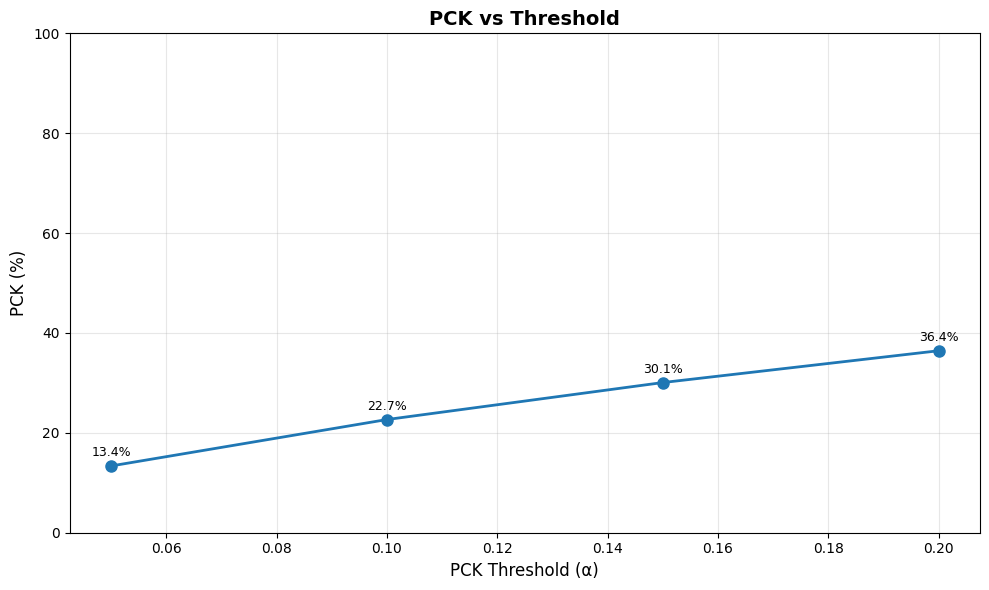

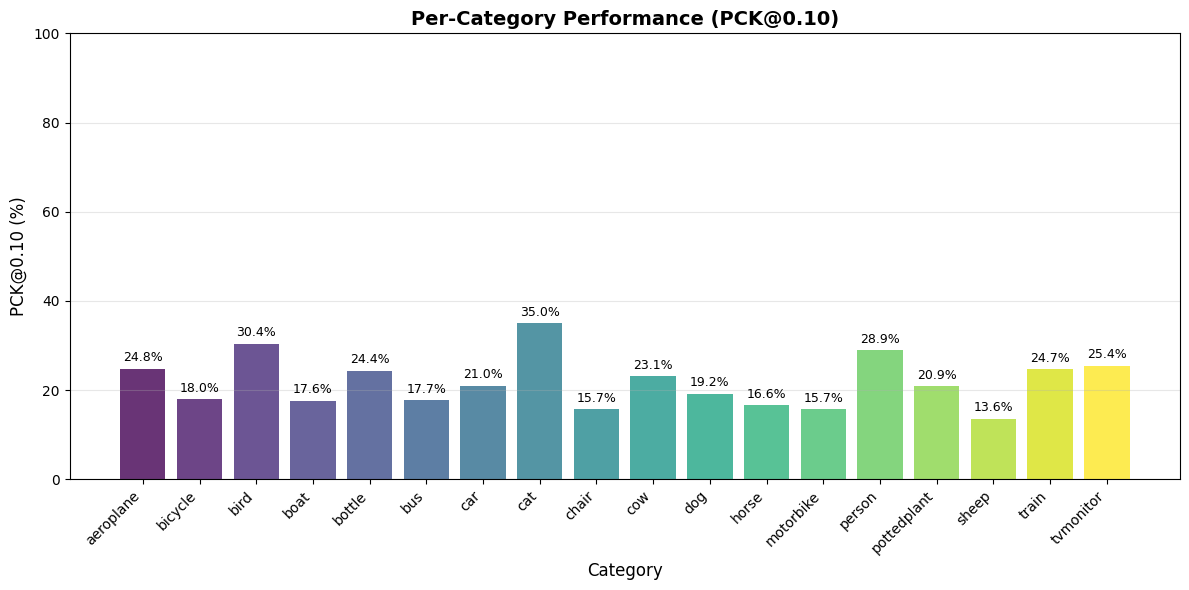

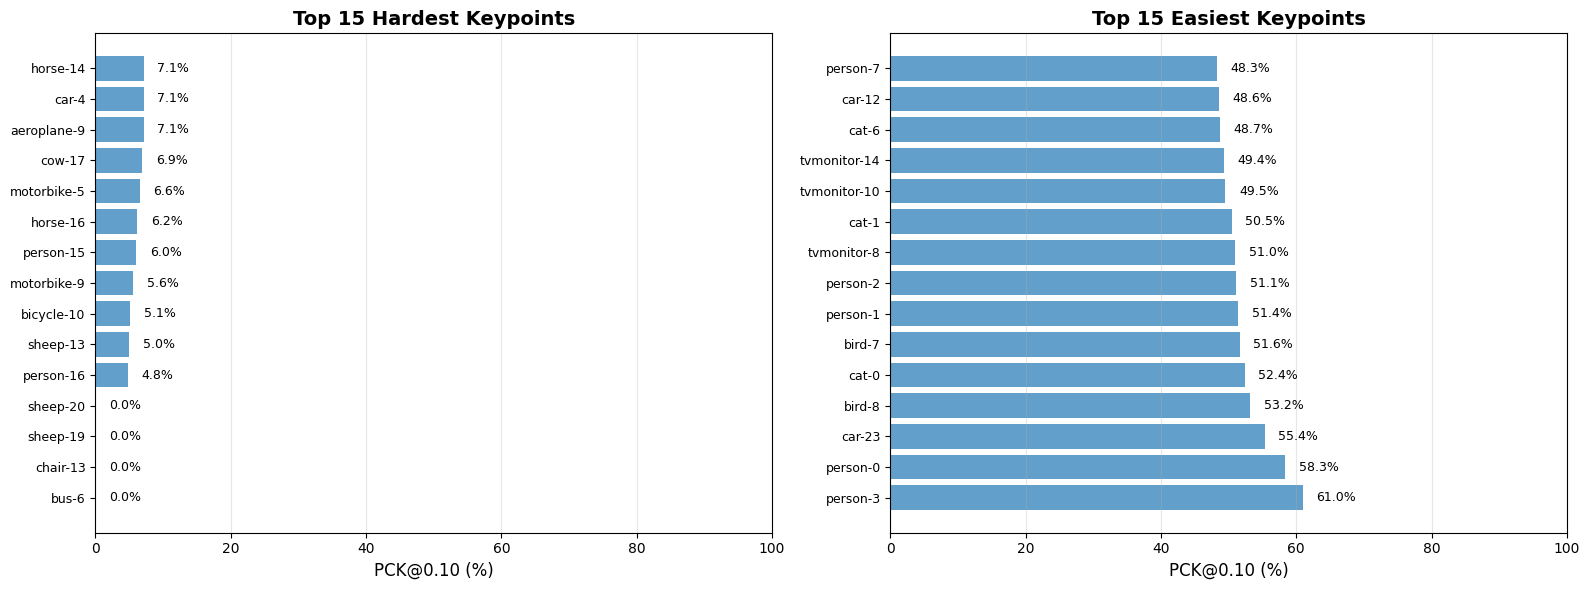

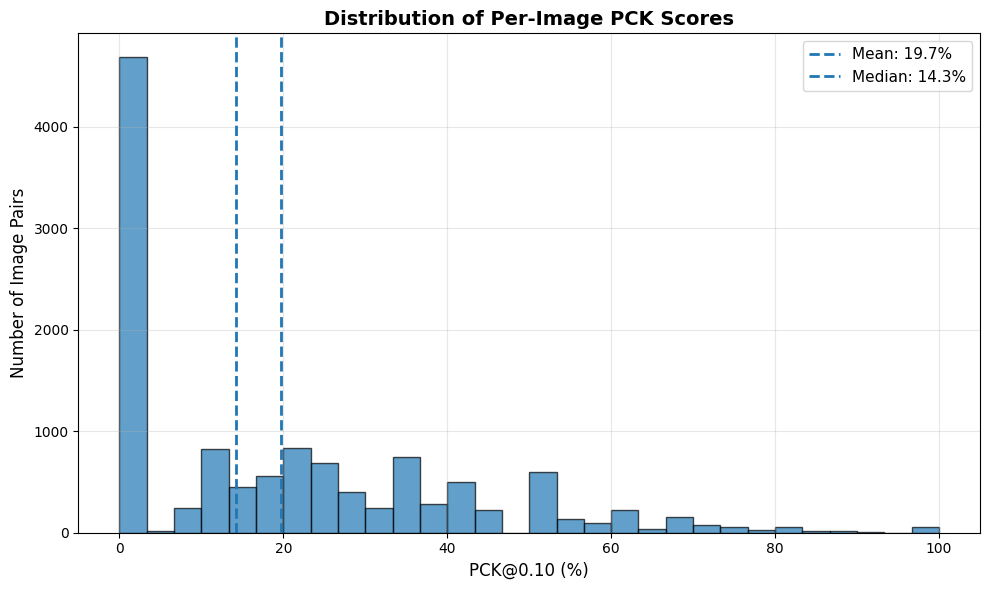

✅ Exported all metrics to ./results/sam_vit_b/
✅ Report generated in ./results/sam_vit_b/
   Overall PCK  aeroplane    bicycle       bird      boat     bottle  \
0    22.663255  24.827336  18.003104  30.358786  17.60189  24.384927   

         bus        car        cat      chair        cow        dog  \
0  17.708799  20.991091  35.011294  15.662651  23.086973  19.158684   

       horse  motorbike     person  pottedplant      sheep      train  \
0  16.645408  15.667255  28.933892    20.925598  13.552632  24.734411   

   tvmonitor  
0  25.415192  


In [15]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/sam_vit_b')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

In [16]:
# zipping the results for downloading
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/sam_vit_b/ (stored 0%)
  adding: results/sam_vit_b/per_keypoint_pck.csv (deflated 78%)
  adding: results/sam_vit_b/image_distribution.png (deflated 26%)
  adding: results/sam_vit_b/pck_curve.png (deflated 26%)
  adding: results/sam_vit_b/keypoint_difficulty.png (deflated 25%)
  adding: results/sam_vit_b/per_category_pck.csv (deflated 54%)
  adding: results/sam_vit_b/per_image_pck.csv (deflated 82%)
  adding: results/sam_vit_b/per_category.png (deflated 21%)
  adding: results/sam_vit_b/overall_pck.csv (deflated 20%)


# Part fine-tunning


In [ ]:
!find /content/drive/MyDrive -maxdepth 1 -type d


/content/drive/MyDrive
/content/drive/MyDrive/ReelsBlocker-master
/content/drive/MyDrive/semantic-correspondance-project (1)


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/semantic-correspondance-project (1)"
import os
assert os.path.isdir(PROJECT_DIR), f"Introuvable: {PROJECT_DIR}"

%cd $PROJECT_DIR
print("OK, on travaille ici:", PROJECT_DIR)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/drive
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1121172634.py", line 8, in <cell line: 0>
    get_ipython().run_line_magic('cd', '$PROJECT_DIR')
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
                              ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
             ^^^^^^^^^^^
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception

In [ ]:
!rm -rf semantic-correspondence

!git clone https://github.com/MarcotteS/semantic-correspondence.git
import sys
sys.path.append('/content/semantic-correspondence/src')

import fine_tunning.test as ft
import importlib
importlib.reload(ft)

from fine_tunning.test import CorrespondenceMatcher2
from evaluation import CorrespondenceEvaluator,evaluate_model
from analyzer import ResultsAnalyzer
from correspondence import CorrespondenceMatcher
from models import DINOv2Extractor,DINOv3Extractor,SAMExtractor
from dataset import SPairDataset,denorm,draw_image_with_keypoints,visualize_sample,collate_fn_correspondence





shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
rm: cannot remove 'semantic-correspondance': Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
fatal: could not create work tree dir 'semantic-correspondance': Transport endpoint is not connected


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4057796386.py", line 9, in <cell line: 0>
    importlib.reload(ft)
  File "/usr/lib/python3.12/importlib/__init__.py", line 128, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1262, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1532, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1501, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1372, in __iter__
  File "<frozen importlib._bootstrap_external>", line 1361, in _recalculate
  File "<frozen importlib._bootstrap_external>", line 1504, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1483,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4057796386.py", line 9, in <cell line: 0>
    importlib.reload(ft)
  File "/usr/lib/python3.12/importlib/__init__.py", line 128, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1262, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1532, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1501, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1372, in __iter__
  File "<frozen importlib._bootstrap_external>", line 1361, in _recalculate
  File "<frozen importlib._bootstrap_external>", line 1504, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1483,

In [ ]:
!ls /content/drive/MyDrive/semantic-correspondance-project/checkpoints

ls: cannot access '/content/drive/MyDrive/semantic-correspondance-project/checkpoints': No such file or directory


In [ ]:
extractor = DINOv2Extractor(model_name="dinov2_vitb14")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
image_size = 224 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='trn',
        img_size=image_size,
        category='all'
    )

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k trn annotations...


100%|██████████| 53340/53340 [00:08<00:00, 5974.43it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


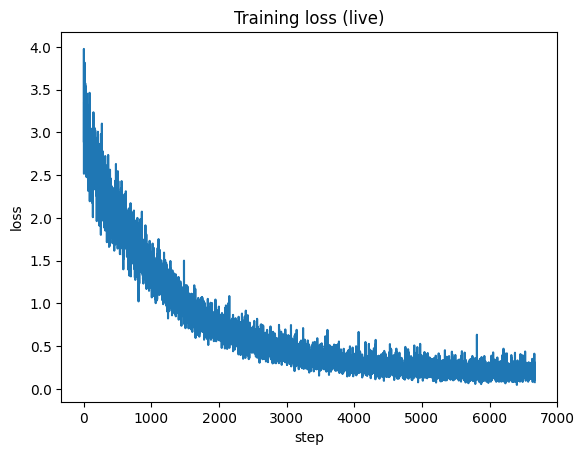

[ckpt] déjà à 2 epochs (objectif=2) -> skip training


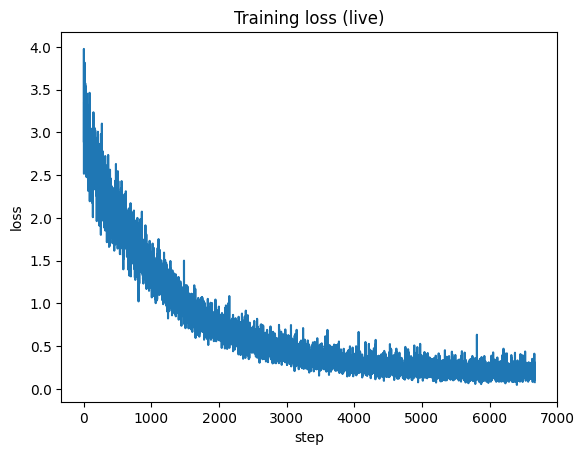

In [ ]:

matcher = CorrespondenceMatcher2(extractor)
matcher.ckpt_dir = "/content/drive/MyDrive/semantic-correspondance-project (1)/checkpoints"
matcher.exp_name = "DINOv2Config1"   # optionnel
matcher.resume = True                   # optionnel
matcher.save_every_epoch = 1            # optionnel
from fine_tunning.test import train_stage2
matcher = train_stage2(
    matcher=matcher,
    train_loader=train_loader,
    n_epochs=2,            # 1-3
    n_last_blocks=1,       # 1 sur Colab
    lr=2e-5,
    weight_decay=0.01,
    tau=0.07,
    max_batches_per_epoch=3000000,  # pour limiter le temps (optionnel)
    use_amp=True
)

Loading SPair-71k test annotations...


Evaluating: 100%|██████████| 765/765 [06:20<00:00,  2.01it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 27.48%
  PCK@0.10: 47.22%
  PCK@0.15: 56.92%
  PCK@0.20: 63.19%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 42.69% | 0.10: 64.10% | 0.15: 72.81% | 0.20: 78.21%
  bicycle         → 0.05: 22.87% | 0.10: 40.20% | 0.15: 50.67% | 0.20: 57.35%
  bird            → 0.05: 37.44% | 0.10: 64.24% | 0.15: 74.63% | 0.20: 81.55%
  boat            → 0.05: 11.90% | 0.10: 26.64% | 0.15: 35.62% | 0.20: 42.32%
  bottle          → 0.05: 16.05% | 0.10: 30.60% | 0.15: 38.43% | 0.20: 44.50%
  bus             → 0.05: 30.79% | 0.10: 53.86% | 0.15: 63.38% | 0.20: 68.74%
  car             → 0.05: 27.14% | 0.10: 49.30% | 0.15: 58.10% | 0.20: 63.47%
  cat             → 0.05: 55.86% | 0.10: 73.06% | 0.15: 77.67% | 0.20: 81.90%
  chair           → 0.05: 18.54% | 0.10: 31.68% | 0.15: 39.24% | 0.20: 45.43%
  cow             → 0.0

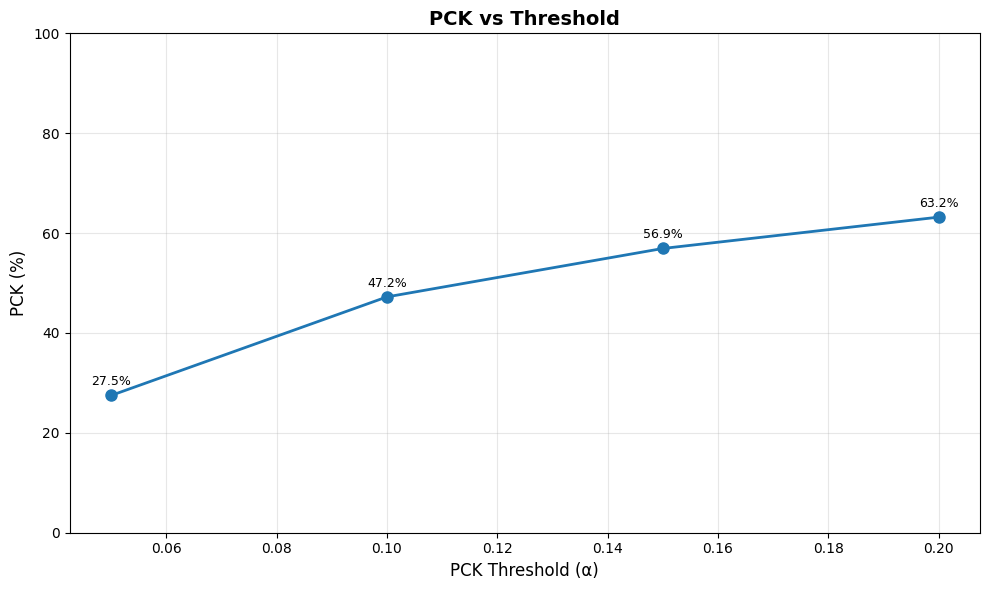

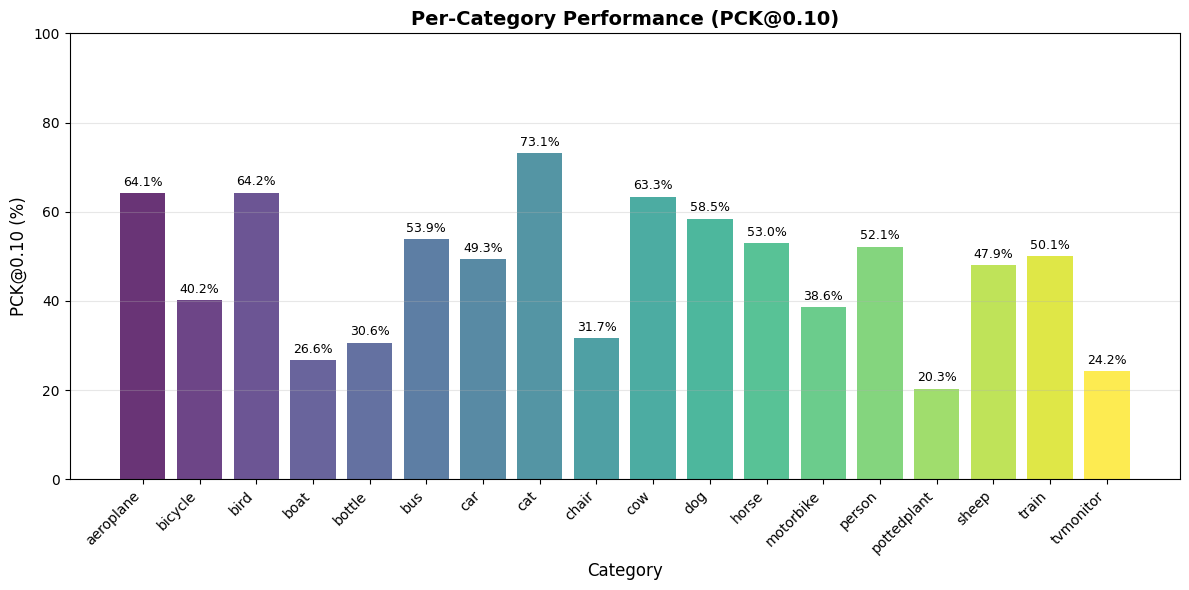

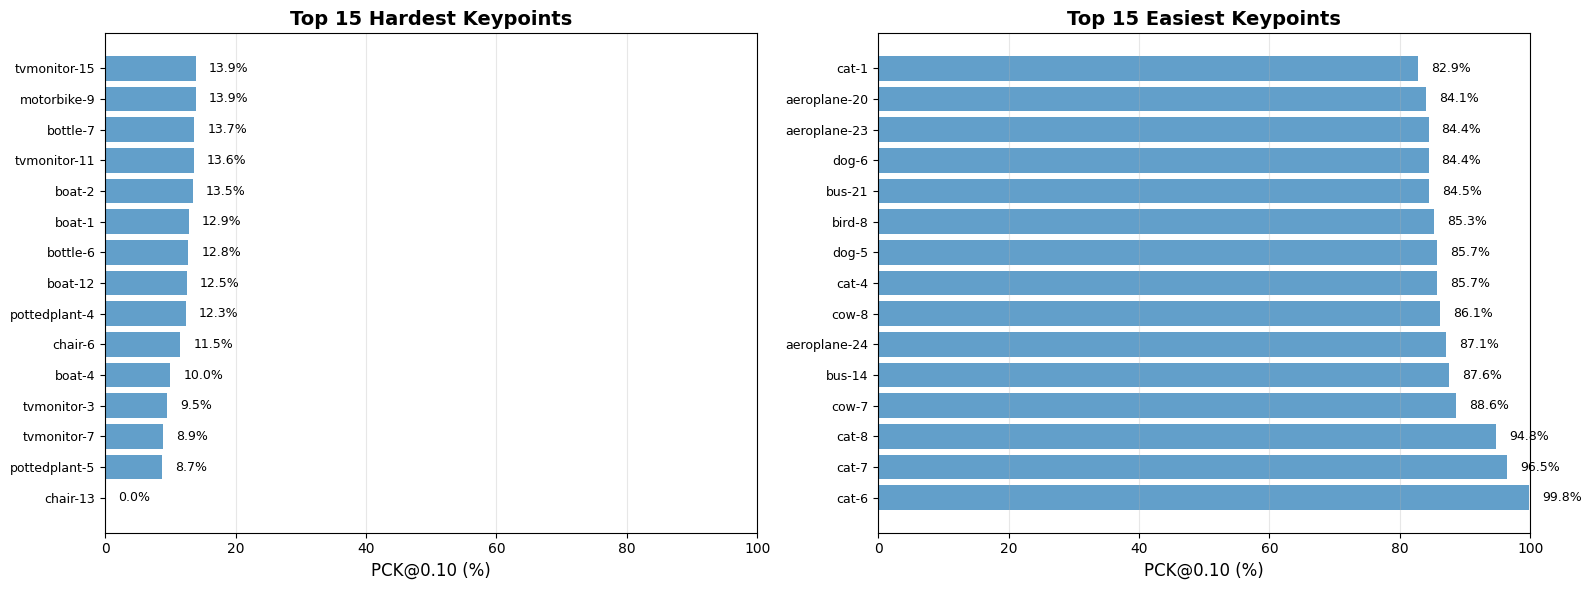

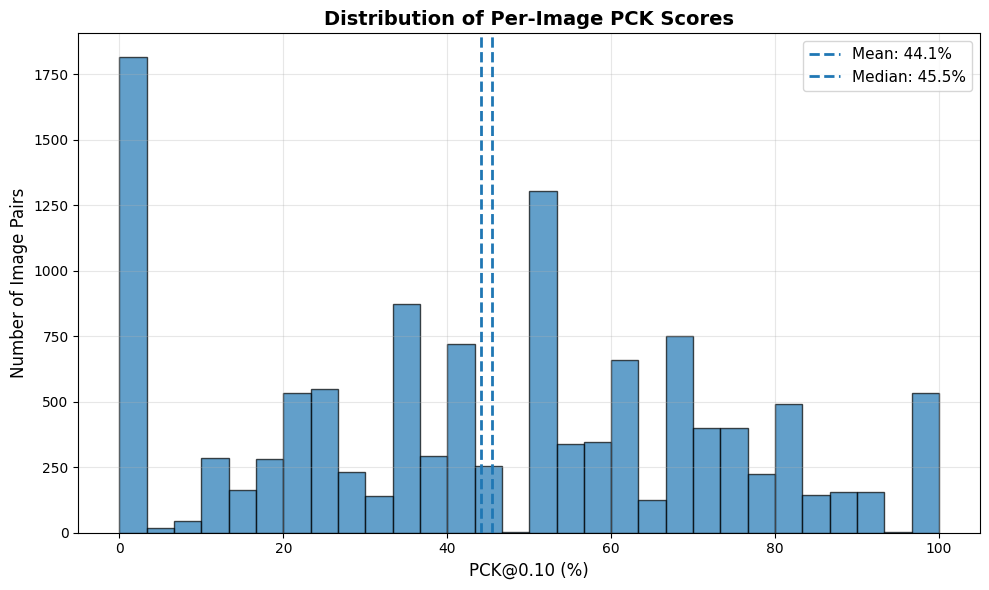

✅ Exported all metrics to ./results/dinov2_vitb14_finetunened/
✅ Report generated in ./results/dinov2_vitb14_finetunened/
   Overall PCK  aeroplane    bicycle       bird       boat     bottle  \
0    47.221719  64.103962  40.196586  64.236431  26.639102  30.597945   

         bus        car        cat      chair        cow        dog     horse  \
0  53.863332  49.304009  73.055824  31.681271  63.344532  58.475635  52.97619   

   motorbike    person  pottedplant      sheep      train  tvmonitor  
0  38.594944  52.11825    20.349867  47.947368  50.069284  24.203648  


In [ ]:
# On réutilise le même extractor (poids fine-tunés)
matcher_eval = CorrespondenceMatcher(extractor)
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)
metrics_after = evaluate_model(matcher_eval, dataloader,run_name="DINOv2Config1metrics")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics_after,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")
analyzer = ResultsAnalyzer(metrics_after)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov2_vitb14_finetunened')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)